# Benchmark M2.1: Water flow in soil - Infiltration

*by Daniel Leitner, Andrea Schnepf, Valentin Couvreur, Axelle Koch*

In [1]:
import numpy as np
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
import ast
from van_genuchten import * 

## Comparison of numerical solutions to reference solution

There are many softwares solving Richards equation. Benchmark M2.1 was evaluated for *Macro*, *Hydrus1D*, *Swap*, *Marthe*, and *Wave* in Vanderborght et al. (2005). With this Jupyter Notebook, we enable automated comparison of the results of additional numerical codes. The easiest way to contribute is to implement this benchmark problem and provide the results to be stored in the specified folder on the github repository.  

In addition, we provide links to Jupyter Notebooks that describe the numerical implementation of a benchmark problem in a specific code if available in sub-folder 'M2.1 Model descriptions'.

### Result data format of M2.1

For an automatic comparison of the numerical results, results are stored in a text file, each result consisting of two rows containing comma separated depth values [cm] in the first, and water content [1] in the second row. This is done for each time point and infiltration scenario (i.e. 2 (rows) * 3 (time points) * 3 (scenarios) results = 18 rows). The file must be located in the sub-folder 'M2.1 Numerical results'.

### Comparison to the analytical solution

First we define the soil parameters for the scenarios

In [2]:
sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50)
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10)

We prepare the analytical solution and store the results in *theta3*[1] holding the water content, and *z3* [cm] the corresponding vertical position.

In [3]:
tv=[ [0.1, 0.2, 0.3], [0.2, 0.5, 1.0], [0.1, 0.2, 0.5] ] # time values (days)
t_a2 = [0.1, 0.2, 0.1] 
x_aa = [43, 41, 27.5]     
theta3 = []
z3 = []

for i, soil in enumerate([sand, loam, clay]):
        
    if soil==sand:
        theta_sur = 0.2824 # calculated form the influx 100 cm/day
    else:
        theta_sur = soil.theta_S  # full saturation          
    theta_i = water_content(-400,soil);
        
    K_sur = hydraulic_conductivity( pressure_head(theta_sur,soil), soil);
    K_i = hydraulic_conductivity(-400, soil)
    psi = lambda theta: pressure_head(theta,soil)
    K = lambda psi: hydraulic_conductivity(psi,soil)
    Dw = lambda psi: K(psi)/(specific_moisture_storage(psi,soil))            
    F = lambda theta:  Dw(psi(theta)) / ( (K_sur - K_i)*(theta - theta_i) - (K(psi(theta)) - K_i)*(theta_sur - theta_i) ) 
    
    theta_a = (theta_sur+theta_i)/2
    theta_ = np.linspace (theta_i+1e-3,theta_sur-1e-3,2000)

    delta_eta = np.zeros(len(theta_),)
    for j in range(0,len(theta_)):
        ans, err = integrate.quad(F,theta_[j],theta_a)
        delta_eta[j] = ans
    
    delta_eta = delta_eta * (theta_sur - theta_i)
    x_a = x_aa[i]
    t_a = t_a2[i]        
    eta_a = x_a - (K_sur-K_i)/(theta_sur - theta_i)*t_a
    eta = delta_eta + eta_a
 
    for j in range(0,len(tv[0])):
        t = tv[i][j]
        x = eta  + (K_sur - K_i) * t / (theta_sur - theta_i);
        theta3.append(theta_)
        z3.append(-x)

We plot the analytical solutions, and then open all files representing the numerical solution of the different simulators, to create a graph that summarizes the results.

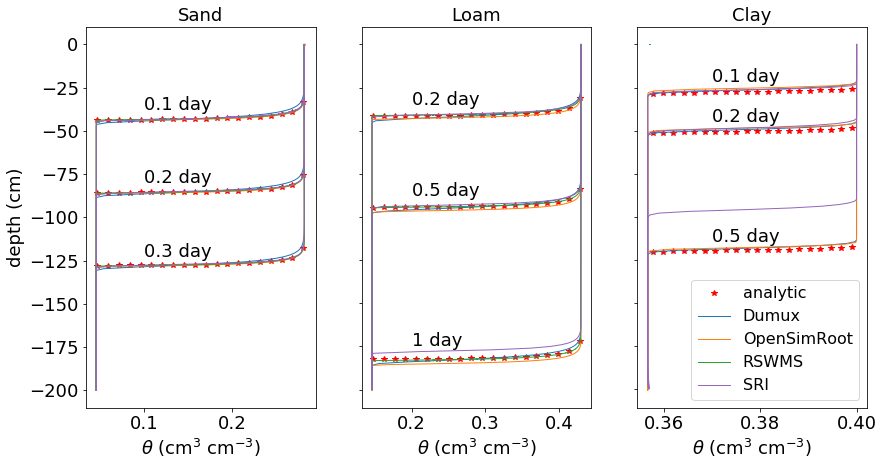

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))  
        
for j in range(0,3): # make sub plots of the analytical solution (theta3, z3) that was created before
    for k in range(0,3): 
        z = z3[3*j+k]
        theta = theta3[3*j+k]
        interp = interp1d(theta, z,  kind='linear', fill_value='extrapolate', bounds_error =False ) 
        theta_ = np.linspace(np.min(theta),np.max(theta),20)  
        z_ = interp(theta_)       
        pl, = ax[j].plot(theta_,z_,'r*') # Analytic solution
        if k==0:
            pl.set_label("analytic")     

lsoils = ["Sand", "Loam", "Clay"]
ltimes = [[0 for x in range(3)] for y in range(3)] 
ltimes[0][0]=0.1; ltimes[0][1]=0.2; ltimes[0][2]=0.3; ltimes[1][0]=0.2; 
ltimes[1][1]=0.5; ltimes[1][2]=1.0; ltimes[2][0]=0.1; ltimes[2][1]=0.2; ltimes[2][2]=0.3
nrmse, nnse, zn, nn, l, lsoil, ltime = [], [], [], [], [], [], []

cc = 0
for dirname, dirnames, filenames in os.walk('M2.1 Numerical results/.'):    
    filenames.sort()
    for i,f in enumerate(filenames):            
        try:        
            data = []
            with open('M2.1 Numerical results/'+f) as fp: 
                for line in fp:
                    line = line.replace("NaN", "0.")                    
                    s = ast.literal_eval("["+line+"]")                
                    data.append(s)                      
            for j in range(0,3): # scenario                
                for k in range(0,3): # times
                    l.append(f)                     
                    ltime.append(ltimes[j][k])
                    z = data[2*(3*j+k)]
                    theta = data[2*(3*j+k)+1]                     
                    pl, = ax[j].plot(theta, z, color = col[cc,:], linewidth = 1, alpha = 1) # plot numeric solution   
                    # interpolate analytical solution to number of evaluation points
                    za = z3[3*j+k]; thetaa = theta3[3*j+k]
                    interp = interp1d(thetaa, za,  kind='linear', fill_value='extrapolate', bounds_error =False ) 
                    theta_ = np.linspace(np.min(thetaa)+0.002,np.max(thetaa)-0.002,100)  
                    z_ = interp(theta_) 
                    # interpolate numerical solution to number of evaluation points                    
                    interp = interp1d(theta, z,  kind='linear', fill_value='extrapolate', bounds_error =False ) 
                    z_n = interp(theta_) 
                    # compute measures for the table below
                    lsoil.append(lsoils[j]) 
                    zn.append(z_n)                    
                    nn.append(len(z_n))
                    nrmse.append(float(nRMSE(z_, z_n)))                    
                    nnse.append(nNSE(z_,z_n)) # calculate for all time points (below)
                    if k==0:
                        pl.set_label(f)                                      
                ax[j].set_xlabel("$\\theta$ (cm$^3$ cm$^{-3}$)")
                if j==0: 
                    ax[j].set_ylabel("depth (cm)") 
                else:
                    ax[j].set_yticklabels([])  
            cc+=1 # different color for each simulator                               
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(line[-50:])
            raise                  
            
ax[-1].legend() 
ax[0].text(0.1, -38, '0.1 day'); ax[0].text(0.1, -80, '0.2 day'); ax[0].text(0.1, -123, '0.3 day')
ax[1].text(0.2, -35, '0.2 day'); ax[1].text(0.2, -88, '0.5 day'); ax[1].text(0.2, -175, '1 day')
ax[2].text(0.37, -22, '0.1 day'); ax[2].text(0.37, -45, '0.2 day'); ax[2].text(0.37, -115, '0.5 day')
ax[0].set_title('Sand')
ax[1].set_title('Loam')
ax[2].set_title('Clay')
plt.savefig('m21_results.png', dpi=300, bbox_inches = "tight")
plt.show()

Additionally, we create a table using normalised RSME as an error measure (which were calculated in the cell above)

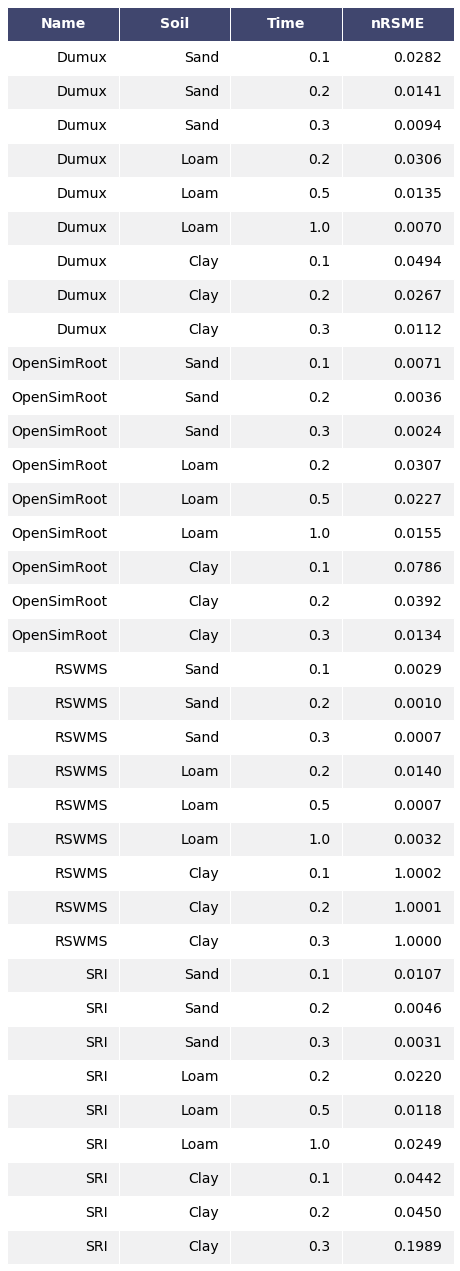

In [5]:
import pandas as pd 

data_ = np.array([l, lsoil, ltime, nrmse]) # initialize list of lists 
data_ = np.array(data_.transpose())
df = pd.DataFrame(data_, columns = ['Name','Soil','Time','nRSME'] ) # Create the pandas DataFrame 
df['Time'] = df['Time'].astype(float)
df['Time'] = df['Time'].map('{:,.1f}'.format)
df['nRSME'] = df['nRSME'].astype(float)
df['nRSME'] = df['nRSME'].map('{:,.4f}'.format)
#df['nNSE'] = df['nNSE'].astype(float)
#df['nNSE'] = df['nNSE'].map('{:,.4f}'.format)
df.style.set_table_styles(
[{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},
]
).hide_index()

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
fig.savefig("table_m2l.png")

## References

Vanderborght, J., Kasteel, R., Herbst, M., Javaux, M., Thiery, D., Vanclooster, M., Mouvet, C., and Vereecken, H. (2005) A set of analytical benchmarks to test numerical models of flow and transport in soils. *Vadose Zone Journal*, 4(1):206-221.